In [1]:
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
from tqdm import tqdm
import dask
import dask_geopandas as dgp
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from shapely.geometry import Point, Polygon
import libpysal
import pandas as pd
from libpysal.weights import W
import momepy
import pickle
import contextily as ctx

c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
place = "glasgow"
local_crs = 27700
latlng = (-4.251846930489373, 55.86421405612109)

In [3]:
local_crs = 3414
place = "singapore"
lat = 1.28795311
lng = 103.851784
crs=4326

In [4]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55533 instead
  warnings.warn(
2023-12-06 01:45:01,850 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-06 01:45:01,868 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-06 01:45:01,886 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-06 01:45:01,904 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-06 01:45:01,923 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 63.92 GiB
2023-12-06 01:45:01,940 - distributed.nanny.memory - WARNING - Ign

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55533/status,
Dashboard: http://127.0.0.1:55533/status,Workers: 8
Total threads: 16,Total memory: 511.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55534,Workers: 8
Dashboard: http://127.0.0.1:55533/status,Total threads: 16
Started: Just now,Total memory: 511.38 GiB
Comm: tcp://127.0.0.1:55577,Total threads: 2
Dashboard: http://127.0.0.1:55581/status,Memory: 63.92 GiB
Nanny: tcp://127.0.0.1:55537,


In [5]:
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_p1.pq").to_crs(local_crs)
buildings = gpd.read_parquet(f"./output/{place}/buildings_p1.pq").to_crs(local_crs)
rail = gpd.read_parquet(f"./output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).explode()

C:\Users\reube\AppData\Local\Temp\ipykernel_30356\1555334706.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").to_crs(local_crs).explode()


In [6]:
study_area = gpd.read_parquet(f"./output/{place}/study_area.pq").to_crs(local_crs)

In [7]:
buildings[~buildings.geom_type.eq('Polygon')]

,uID,geometry
60785,60785,"MULTIPOLYGON (((48041.439 11320.135, 48041.076..."
121820,121820,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121821,121821,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121822,121822,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121823,121823,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121824,121824,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121825,121825,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121826,121826,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121827,121827,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121828,121828,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."


In [8]:
buildings[buildings["uID"] == 48]

,uID,geometry
48,48,"POLYGON ((39068.693 46187.825, 39068.758 46183..."


In [9]:
buildings.geom_type.eq('Polygon').all()
buildings[~buildings.geom_type.eq('Polygon')]

,uID,geometry
60785,60785,"MULTIPOLYGON (((48041.439 11320.135, 48041.076..."
121820,121820,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121821,121821,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121822,121822,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121823,121823,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121824,121824,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121825,121825,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121826,121826,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121827,121827,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."
121828,121828,"MULTIPOLYGON (((41445.134 50980.672, 41436.479..."


In [10]:
tessellation.is_valid.eq('Polygon').all()
tessellation[~tessellation.geom_type.eq('Polygon')]

,uID,geometry
25,25,"MULTIPOLYGON (((28616.945 51235.719, 28631.754..."
30,30,"MULTIPOLYGON (((20771.988 48651.085, 20768.164..."
41,41,"MULTIPOLYGON (((46126.515 64413.496, 46126.804..."
50,50,"MULTIPOLYGON (((50767.877 54265.790, 50767.219..."
60,60,"MULTIPOLYGON (((32161.746 49234.916, 32161.143..."
...,...,...
362123,362123,"MULTIPOLYGON (((54792.399 40780.977, 54792.258..."
362125,362125,"MULTIPOLYGON (((55521.188 43134.808, 55521.736..."
362138,362138,"MULTIPOLYGON (((54377.707 40633.477, 54377.534..."
362142,362142,"MULTIPOLYGON (((54567.235 42915.603, 54560.831..."


In [11]:
# Load your GeoDataFrame
gdf = tessellation

# Calculate the extent of the dataset
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Modify the create_grid function to include tqdm
def create_grid(bounds, width, height):
    minx, miny, maxx, maxy = bounds
    grid = []
    x_range = range(int((maxx - minx) / width)+1)
    y_range = range(int((maxy - miny) / height)+1)

    for x in tqdm(x_range, desc="Creating Grid"):
        x_coord = minx + x * width
        for y in y_range:
            y_coord = miny + y * height
            grid.append(box(x_coord, y_coord, x_coord + width, y_coord + height))

    return grid

grid_squares = create_grid(bounds, 6000, 6000) 

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_squares)

Creating Grid: 100%|██████████| 14/14 [00:00<00:00, 1353.63it/s]


In [12]:
tessellation.crs

<Projected CRS: EPSG:3414>
Name: SVY21 / Singapore TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Singapore - onshore and offshore.
- bounds: (103.59, 1.13, 104.07, 1.47)
Coordinate Operation:
- name: Singapore Transverse Mercator
- method: Transverse Mercator
Datum: SVY21
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

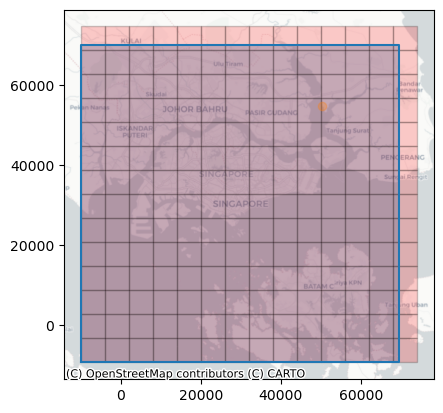

In [13]:


# Example: Assuming gdf is your GeoDataFrame
# gdf = gpd.read_file('your_file.geojson') or any other source

# Get the total bounds
bounds = gdf.total_bounds

# Create a polygon from the bounds
# The order of points is: bottom-left, top-left, top-right, bottom-right
polygon = Polygon([(bounds[0], bounds[1]), (bounds[0], bounds[3]), 
                   (bounds[2], bounds[3]), (bounds[2], bounds[1])])

# Optional: Plotting
fig, ax = plt.subplots()
x,y = polygon.exterior.xy
plt.plot(x, y)
plt.fill(x, y, alpha=0.3)
grid_gdf.plot(ax=ax, color='red', alpha=0.2, edgecolor='black')
tessellation[tessellation["uID"] == 0].geometry.centroid.plot(ax=ax, alpha = 0.3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=tessellation.crs)
plt.show()

In [14]:
grid_gdf.to_parquet(f"output/{place}/grid_gdf.pq")

In [15]:
grid_gdf["uID"] = grid_gdf.index

In [16]:
def find_neighbours(tessellation, cell):
    # Get 'not disjoint' countries
    neighbours = tessellation[~tessellation.geometry.disjoint(cell.geometry)].uID.tolist()
    # Remove own uID of the cell from the list
    neighbours_list = [uID for uID in neighbours if cell.uID != uID]
    return neighbours_list

out = []

for index, cell in grid_gdf.iterrows():
    # Add the delayed task to the current batch
    result = find_neighbours(grid_gdf, cell)
    out.append(result)

In [17]:
grid_gdf["touching"] = out

In [18]:
# Step 1: Calculate centroids
tessellation['centroid'] = tessellation.geometry.centroid

# Step 2: Convert centroids to a new GeoDataFrame
centroids = gpd.GeoDataFrame(tessellation, geometry='centroid')

# Step 3: Perform spatial join
joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')

# Step 4: Group original polygons based on the join
grouped_gdf = tessellation.merge(joined_gdf[['centroid', 'index_right']], left_on='centroid', right_on='centroid')


c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\reube\AppData\Local\Temp\ipykernel_30356\2368018611.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3414
Right CRS: None

  joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')


In [19]:

# Assuming you have a GeoDataFrame 'grouped_gdf' and you're grouping by some column 'grouping_column'
grouped = grouped_gdf.groupby('index_right')

cells_in_region = {region:set() for region in grid_gdf.uID}


In [20]:
# Extracting the uID lists for each group
for group_name, group in grouped:
    cells_in_region[group_name] = set(group['uID'].tolist())

In [21]:
# Assuming 'grouped_gdf' is your GeoDataFrame and it's correctly defined
buffered_tessellation = grouped_gdf.copy()  # Create a copy to retain the original data

# Apply a buffer of 50 units to each geometry
buffered_tessellation["geometry"] = buffered_tessellation["geometry"].buffer(60)


In [22]:
cells_in_expanded_region = cells_in_region.copy()

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation[buffered_tessellation['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry.boundary)]
    
    cells_in_expanded_region[index] = cells_in_region[index].union(set(intersection_rows.uID.tolist()))
    

100%|██████████| 196/196 [00:03<00:00, 53.06it/s]


In [23]:
# Assuming 'grouped_gdf' is your GeoDataFrame and it's correctly defined
buffered_tessellation_200 = grouped_gdf.copy()  # Create a copy to retain the original data

# Apply a buffer of 50 units to each geometry
buffered_tessellation_200["geometry"] = buffered_tessellation["geometry"].buffer(250)

cells_in_expanded_region_200 = cells_in_region.copy()

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation_200[buffered_tessellation_200['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry.boundary)]
    
    cells_in_expanded_region_200[index] = cells_in_region[index].union(set(intersection_rows.uID.tolist()))
    

100%|██████████| 196/196 [00:04<00:00, 46.66it/s]


In [24]:
list_of_weights = []

for index, expanded_region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cell_gdf = tessellation[tessellation['uID'].isin(list(cells_in_expanded_region[index]))]
    
    list_of_weights.append(libpysal.weights.fuzzy_contiguity(expanded_cell_gdf, tolerance=0.05, buffering=True, drop=True, buffer=5, ids="uID", silence_warnings=True))


  0%|          | 0/196 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\libpysal\weights\util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=["_buffer"], inplace=True)
c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\libpysal\weights\util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=["_buffer"], inplace=True)
c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\libpysal\weights\util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [25]:
adjlist_combined = None
for index, weight in tqdm(enumerate(list_of_weights), total= len(list_of_weights)):
    
    adjlist = list_of_weights[index].to_adjlist()
    
    if index == 0:
        adjlist_combined = adjlist
    
    else:
        adjlist_combined = pd.concat([adjlist_combined, adjlist])

100%|██████████| 196/196 [00:05<00:00, 35.21it/s]


In [26]:
unique_ids = tessellation['uID'].unique().tolist()

In [27]:
uID_neighbours = {uID: set() for uID in unique_ids}

In [28]:
tessellation[tessellation["uID"] == 557021]

,uID,geometry,centroid


In [29]:
adjlist_combined

,focal,neighbor,weight
0,162.0,236829.0,1.0
1,230812.0,231183.0,1.0
2,230812.0,231961.0,1.0
3,230812.0,233381.0,1.0
4,230812.0,234554.0,1.0
...,...,...,...
99,241224.0,240007.0,1.0
100,241224.0,240298.0,1.0
101,241224.0,241314.0,1.0
102,241314.0,240007.0,1.0


In [30]:
for index, row in adjlist_combined.iterrows():
    uID_neighbours[row["focal"]].add(row["neighbor"])

In [31]:
three_queen_region = {}
for region in tqdm(cells_in_region):
    cells_to_search = cells_in_region[region]
    output = cells_in_region[region]
    for i in range(5):
        cells_found_in_current_iteration = set()
        
        for cell in cells_to_search:
            cells_found_in_current_iteration = cells_found_in_current_iteration.union(uID_neighbours[cell])
        
        cells_to_search = cells_found_in_current_iteration.difference(output)
        
        output = output.union(cells_found_in_current_iteration)
        
    three_queen_region[region] = output

100%|██████████| 196/196 [00:52<00:00,  3.72it/s]


<Axes: >

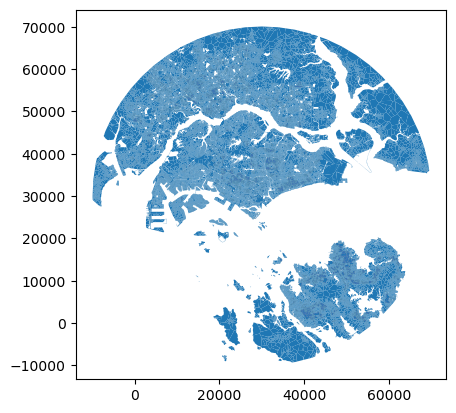

In [35]:
tessellation.plot()

In [33]:
with open(f"output/{place}/three_queen_region.pq", 'wb') as file:
    pickle.dump(three_queen_region, file)

## Morphometrics

In [36]:
## Create Weights
buildings_local_out_combined = pd.DataFrame()
buildings_dist200_combined = pd.DataFrame()
tessellation_out_combined = pd.DataFrame()

for cell_index in tqdm(three_queen_region):
    print("new cell", cell_index)
    
    if buildings[buildings['uID'].isin(three_queen_region[cell_index])].empty:
        continue
    
    filtered_df = adjlist_combined[
            adjlist_combined['focal'].isin(three_queen_region[cell_index]) & 
            adjlist_combined['neighbor'].isin(three_queen_region[cell_index])
        ]
    buildings_dist200 = buildings[buildings["uID"].isin(cells_in_expanded_region_200)]
    
    queen_1 = W.from_adjlist(filtered_df)

    queen_3 = momepy.sw_high(k=3, weights=queen_1)

    dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings_dist200, 200, ids='uID')
    
    buildings_local = buildings[buildings['uID'].isin(three_queen_region[cell_index])]

    buildings_dist200["buildings_neighbours_200"] = momepy.Neighbors(buildings_dist200, dist200, 'uID', weighted=True).series

    buildings_out = buildings[buildings["uID"].isin(cells_in_region[cell_index])]
    
    queen_3_adjlist = queen_3.to_adjlist()

    # Get unique values from both columns
    unique_focal = queen_3_adjlist['focal'].unique()
    unique_neighbor = queen_3_adjlist['neighbor'].unique()

    # Combine and get unique values across both columns
    all_unique_values = pd.unique(pd.concat([pd.Series(unique_focal), pd.Series(unique_neighbor)]))
    
    tessellation_out = tessellation[tessellation["uID"].isin(all_unique_values)]
    
    ### Building Area
    buildings_local['building_area'] = momepy.Area(buildings_local).series
    tessellation_out['tess_area'] = momepy.Area(tessellation_out).series
    
    tessellation_out["tessellation_neighbours"] = momepy.Neighbors(tessellation_out, queen_3, 'uID', weighted=True).series
    
    buildings_local_scattered = client.scatter(buildings_local)
    streets_scattered = client.scatter(streets)
    tessellation_scattered = client.scatter(tessellation_out)

    dist200_scattered = client.scatter(dist200)
    queen_1_scattered = client.scatter(queen_1)
    queen_3_scattered = client.scatter(queen_3)
    
    buildings_local_out = buildings_local
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined
    
    jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

    jobs = [dask.delayed(momepy.CircularCompactness)(buildings_local_scattered), 
            dask.delayed(momepy.Elongation)(buildings_local_scattered), 
            dask.delayed(momepy.Squareness)(buildings_local_scattered),
            dask.delayed(momepy.EquivalentRectangularIndex)(buildings_local_scattered), 
            dask.delayed(momepy.Orientation)(buildings_local_scattered), 
            dask.delayed(momepy.NeighborDistance)(buildings_local_scattered, queen_1_scattered, 'uID'), 
            dask.delayed(momepy.MeanInterbuildingDistance)(buildings_local_scattered, queen_1_scattered, 'uID', 3)]

    jobs_out = dask.compute(jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        buildings_local_out[field_name] = jobs_out[0][index].series
        
    buildings_local_scattered = client.scatter(buildings_local_out)

    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ["tess_convexity", "tess_covered_area", "tess_orientation"]

    jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
            dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
            dask.delayed(momepy.Orientation)(tessellation_scattered)]

    jobs_out = dask.compute(jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        tessellation_out[field_name] = jobs_out[0][index].series

    tessellation_scattered = client.scatter(tessellation_out)
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

    jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_circular_compactness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_elongation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_squareness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_eri',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbour_dist',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbourhood_interbuilding_distance',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_orientation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID')]

    jobs_out = dask.compute(*jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        buildings_local_out[field_name] = jobs_out[index].series

    buildings_local_scattered = client.scatter(buildings_local_out)
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "tess_rea_theil", "building_neighbourhood_interbuilding_distance_weight"]

    jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values="tess_convexity",
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values='tess_covered_area',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values='tess_orientation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.Theil)(tessellation_scattered, values='tess_area', spatial_weights=queen_3_scattered, unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbourhood_interbuilding_distance_weight',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID')]

    jobs_out = dask.compute(*jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        if index == len(jobs_names) - 1:  # Check if it's the last iteration
            buildings_local_out[field_name] = jobs_out[index].series
        else:
            tessellation_out[field_name] = jobs_out[index].series
            
    buildings_local_out.to_parquet(f"output/{place}/momepy_building_local_out_part{cell_index}.pq")
    buildings_dist200.to_parquet(f"output/{place}/momepy_building_dist200_out_part{cell_index}.pq")
    tessellation_out.to_parquet(f"output/{place}/momepy_tessellation_out_part{cell_index}.pq")
    
    buildings_local_out = buildings_local_out.drop('geometry', axis=1)
    tessellation_out = tessellation_out.drop(['geometry', 'centroid'], axis=1)
    buildings_dist200 = buildings_dist200.drop('geometry', axis=1)
    
    if cell_index == 0:
        buildings_local_out_combined = buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]
        buildings_dist200_combined = buildings_dist200[buildings_dist200["uID"].isin(cells_in_region[cell_index])]
        tessellation_out_combined = tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]
    
    else:
        buildings_local_out_combined = pd.concat([buildings_local_out_combined, buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
        buildings_dist200_combined = pd.concat([buildings_dist200_combined, buildings_dist200[buildings_dist200["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
        tessellation_out_combined = pd.concat([tessellation_out_combined, tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)


  0%|          | 0/196 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 62 disconnected components.
 There are 29 islands with ids: 4, 5, 13, 25, 41, 49, 53, 82, 88, 91, 105, 113, 121, 126, 146, 154, 155, 164, 165, 166, 170, 179, 180, 181, 184, 187, 189, 194, 195.
  warnings.warn(message)
100%|██████████| 196/196 [00:00<00:00, 83324.91it/s]
c:\ProgramData\anaconda3\envs\morph-downloader\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
buildings_local_out_combined.to_parquet(f"output/{place}/buildings_dist200_out_combined.pq")
buildings_dist200_combined.to_parquet(f"output/{place}/buildings_dist200_combined.pq")
tessellation_out_combined.to_parquet(f"output/{place}/tessellation_out_combined.pq")


In [ ]:
continuity = momepy.COINS(streets)

stroke_attr = continuity.stroke_attribute()

stroke_gdf = continuity.stroke_gdf()

stroke_gdf.plot(stroke_gdf.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

stroke_gdf["length"] = stroke_gdf.length

stroke_gdf.to_parquet(f"output/{place}/stroke_gdf.pq")

In [ ]:
buildings

In [ ]:
# buildings = gpd.GeoDataFrame(buildings.merge(buildings_local_out_combined, on='uID', how='inner').merge(buildings_dist200_combined, on='uID', how='inner'), crs=local_crs)
buildings_out = gpd.GeoDataFrame(buildings.merge(buildings_local_out_combined, on='uID', how='inner'), crs=local_crs)
tessellation_out = gpd.GeoDataFrame(tessellation.merge(tessellation_out_combined, on='uID', how='inner'), crs=local_crs)

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(100, 100))

# Plot study_area in green on the same axis
buildings.plot(ax=ax, color='green')

# Plot streets in blue on the same axis
tessellation.plot(ax=ax, color='blue')

# Show the plot
plt.show()

In [ ]:
buildings_out.to_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation_out.to_parquet(f"./output/{place}/tessellation_morphometric_var.pq")

In [ ]:
buildings_out.to_file(f"./output/{place}/buildings_morphometric_var.shp")
tessellation_out.to_file(f"./output/{place}/tessellation_morphometric_var.shp")

In [ ]:
daskcluster.close()
client.shutdown()